# SuperTomo Image Fusion Demo

Here I show how the Image Fusion in Supertomo2 works. The images are from (Koho et al 2015). 

*Koho, S., T. Deguchi, and P. E. E. Hänninen. 2015. “A Software Tool for Tomographic Axial Superresolution in STED Microscopy.” Journal of Microscopy 260 (2): 208–18.*

In [9]:
%matplotlib inline 
import warnings; warnings.simplefilter('ignore')
from ipywidgets import interact, fixed

import sys
import os
import supertomo.data.containers.image_data as image_data
import supertomo.ui.supertomo_options as supertomo_options
import supertomo.processing.fusion.fusion as fusion
import supertomo.processing.fusion.fusion_cuda as gpufusion
import supertomo.ui.plots.image as implot

def open_data_file(path):
    
    if not path.endswith(".hdf5"):
        raise ValueError("Please specify a HDF5 data file")
    if not os.path.exists(path):
        raise ValueError("The specified file %s does not exist" % path)

    return image_data.ImageData(path)

def show_orthogonal_plot(image, x, y, z):
    figure = implot.create_axial_views_plot(image, x, y, z)
    figure.show()


## Open Data

All the image data in **SuperTomo2** is contained within a single *HDF5* data structure. The two views from the STED< experiment were previously registered in [here](http://localhost:8888/notebooks/notebooks/2018-05%20-%20SuperTomo2%20-%20Image%20Registration.ipynb). 

In [10]:
working_directory = "/Users/sami/Documents/Work/Data/2018_05_FSC_paper"
file_name = "supertomo1_hela.hdf5"
full_path = os.path.join(working_directory, file_name)

data = open_data_file(full_path)

## Set up image fusion

The image fusion is typically run through the *supertomo.fuse* command line script that can be found in *supertomo/bin/fuse.py*. In this notebook the same command line interface is used to control the exdecution of the fusion process. The whole command line interface is described below:

In [11]:
%%bash

supertomo.fuse -h

usage: supertomo.fuse [-h] [--verbose] [--dir WORKING_DIRECTORY]
                      [--show-plots] [--show-image] [--scale SCALE]
                      [--channel CHANNEL] [--jupyter] [--test-drive]
                      [--evaluate] [--temp-dir TEMP_DIR] [--disable-cuda]
                      [--max-nof-iterations MAX_NOF_ITERATIONS]
                      [--convergence-epsilon CONVERGENCE_EPSILON]
                      [--first-estimate {first_image,sum_of_all,simple_fusion,first_image_mean,average_of_all,constant}]
                      [--estimate-constant ESTIMATE_CONSTANT]
                      [--save-intermediate-results] [--output-cast]
                      [--fusion-method {multiplicative,multiplicative-opt,summative,summative-opt}]
                      [--blocks NUM_BLOCKS] [--rltv-stop-tau RLTV_STOP_TAU]
                      [--rltv-lambda RLTV_LAMBDA] [--pad BLOCK_PAD]
                      [--fuse-views FUSE_VIEWS] [--memmap-estimates]
                      [--disab

Here in I simulate the command line interface with a single string. 

In [12]:
args_list = ("{} --dir={} --max-nof-iterations=3 --first-estimate=constant " 
        "--fusion-method=summative --scale=50 --blocks=1 --save-intermediate-results "
        "--pad=0 --rltv-lambda=0").format(file_name, working_directory).split(" ") 

args = supertomo_options.get_fusion_script_options(args_list)

if args.scale not in data.get_scales("registered"):
    print "Images at the defined scale do not exist in the data structure." \
          "The original images will be now resampled. This may take a long" \
          "time depending on the image size and the number of views."
    data.create_rescaled_images("registered", options.scale)

if data.get_number_of_images("psf") != data.get_number_of_images("registered"):
    print "Some PSFs are missing. They are going to be calculated from the " \
          "original STED PSF (that is assumed to be at index 0)."
    data.calculate_missing_psfs()

## Run fusion

The fusion can be run with GPU acceleration (**MultiViewFusionRLCuda**) or without (**MultiViewFusionRL**). The former is naturally much faster if available.

In [13]:
task = fusion.MultiViewFusionRL(data, args)
task.execute()

The original image size is 99 512 512
The fusion will be run with 1 blocks
The internal block size is 99 512 512
Preparing image fusion.
Beginning the computation of the 0. estimate
[============>    1/3                  ] E/S/U/N=1/216940/647644341/0, LEAK=-5.90%, TAU1=24.1893348694, TIME=108s, U/ESU=1.000 
Beginning the computation of the 1. estimate
[=================2/3====>             ] ETA:1m50.9s E/S/U/N=2/108982781/538878498/0, LEAK=-5.90%, TAU1=0.155740708113, TIME=111s, U/ESU=0.832 
Beginning the computation of the 2. estimate
[================3/3===================] ETA:0 E/S/U/N=254/264021273/383839754/0, LEAK=-5.90%, TAU1=0.0763238072395, TIME=110s, U/ESU=0.592 

[================3/3===================] ETA:0 The number of iterations reached to maximal count: 3 


## Results

Show result in an orthogonal plot.

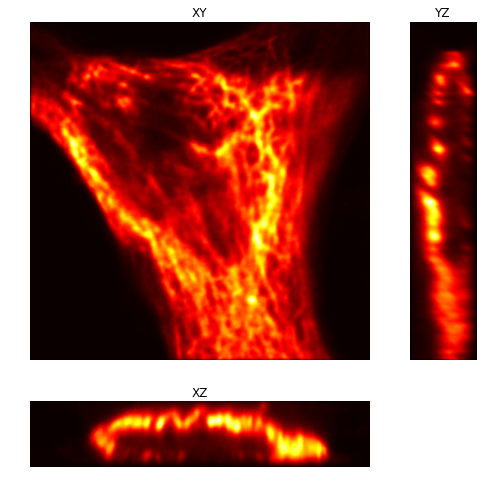

In [17]:
result = task.get_8bit_result()
z_len, y_len, x_len = result.shape


#interact(show_orthogonal_plot, image=fixed(result), x=(0, x_len), y=(0, y_len), z=(0, z_len))
show_orthogonal_plot(result, x=256, y=256, z=49)

In [15]:
data.close()

In [16]:
from supertomo.data.io import write
path = "{}/fusion_result.tiff".format(working_directory)
write.image(path, result)